In [72]:
import os.path as osp
import numpy as np
import torch
from torch_geometric.datasets import AMiner
from torch_geometric.nn import MetaPath2Vec

# MetaPath2Vec

[paper](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf)  
[code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/metapath2vec.py)

In [2]:
# load the dataset
path = osp.join('..', 'data', 'AMiner')
dataset = AMiner(path)
data = dataset[0]


In [3]:
print(data)

Data(
  edge_index_dict={
    ('paper', 'written by', 'author')=[2, 9323605],
    ('author', 'wrote', 'paper')=[2, 9323605],
    ('paper', 'published in', 'venue')=[2, 3194405],
    ('venue', 'published', 'paper')=[2, 3194405]
  },
  num_nodes_dict={
    paper=3194405,
    author=1693531,
    venue=3883
  },
  y_dict={
    author=[246678],
    venue=[134]
  },
  y_index_dict={
    author=[246678],
    venue=[134]
  }
)


In [4]:
print(type(data.edge_index_dict))
print(data.edge_index_dict[('paper', 'written by', 'author')])

<class 'dict'>
tensor([[      0,       1,       2,  ..., 3194404, 3194404, 3194404],
        [      0,       1,       2,  ...,    4393,   21681,  317436]])


In [5]:
print(type(data.num_nodes_dict))
print(data.num_nodes_dict)

<class 'dict'>
{'paper': 3194405, 'author': 1693531, 'venue': 3883}


In [6]:
print(type(data.y_dict))
print(data.y_dict["venue"])

<class 'dict'>
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])


In [7]:
print(type(data.y_index_dict))
print(data.y_index_dict["venue"])

<class 'dict'>
tensor([1741, 2245,  111,  837, 2588, 2116, 2696, 3648, 3784,  313, 3414,  598,
        2995, 2716, 1423,  783, 1902, 3132, 1753, 2748, 2660, 3182,  775, 3339,
        1601, 3589,  156, 1145,  692, 3048,  925, 1587,  820, 1374, 3719,  819,
         492, 3830, 2777, 3001, 3693,  517, 1808, 2353, 3499, 1763, 2372, 1030,
         721, 2680, 3355, 1217, 3400, 1271, 1970, 1127,  407,  353, 1471, 1095,
         477, 3701,   65, 1009, 1899, 1442, 2073, 3143, 2466,  289, 1996, 1070,
        3871, 3695,  281, 3633,   50, 2642, 1925, 1285, 2587, 3814, 3582, 1873,
        1339, 3450,  271, 2966,  453, 2638, 1354, 3211,  391, 1588, 3875, 2216,
        2146, 3765, 2486,  661, 3367,  426,  750, 2158,  519,  230, 1677,  839,
        2945, 1313, 1037, 2879, 2225, 3523, 1247,  448,  227, 3385,  529, 2849,
        1584, 1229,  373, 2235, 1819, 1764, 3155, 2852, 2789, 3474, 1571, 2088,
         208,  462])


In [8]:
# move the data to cpu or GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"

In [9]:
# define the model

metapath = [
    ('author', 'wrote', 'paper'),
    ('paper', 'published in', 'venue'),
    ('venue', 'published', 'paper'),
    ('paper', 'written by', 'author'),
]


model = MetaPath2Vec(data.edge_index_dict, 
                     embedding_dim=128,
                     metapath=metapath,
                     walk_length=5, 
                     context_size=3,
                     walks_per_node=3,
                     num_negative_samples=1,
                     sparse=True
                    ).to(device)


In [10]:
# use the loader to build a loader
loader = model.loader(batch_size=128, shuffle=True, num_workers=3)

In [11]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    if idx == 10: break
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([1536, 3]) torch.Size([1536, 3])
1 torch.Size([1536, 3]) torch.Size([1536, 3])
2 torch.Size([1536, 3]) torch.Size([1536, 3])
3 torch.Size([1536, 3]) torch.Size([1536, 3])
4 torch.Size([1536, 3]) torch.Size([1536, 3])
5 torch.Size([1536, 3]) torch.Size([1536, 3])
6 torch.Size([1536, 3]) torch.Size([1536, 3])
7 torch.Size([1536, 3]) torch.Size([1536, 3])
8 torch.Size([1536, 3]) torch.Size([1536, 3])
9 torch.Size([1536, 3]) torch.Size([1536, 3])


In [12]:
print(pos_rw[0],neg_rw[0])

tensor([1077290, 3179853, 4891621]) tensor([1077290, 3409655, 4890161])


In [13]:
# Inizialize optimizer
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [14]:
def train(epoch, log_steps=500, eval_steps=1000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            acc = test()
            print((f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                   f'Acc: {acc:.4f}'))

@torch.no_grad()
def test(train_ratio=0.1):
    model.eval()

    z = model('author', batch=data.y_index_dict['author'])
    y = data.y_dict['author']

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return model.test(z[train_perm], y[train_perm], z[test_perm],
                      y[test_perm], max_iter=150)


In [ ]:
for epoch in range(1, 2):
    train(epoch)
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

# load the model

In [15]:
loaded_model = MetaPath2Vec(data.edge_index_dict, 
                     embedding_dim=128,
                     metapath=metapath,
                     walk_length=5, 
                     context_size=3,
                     walks_per_node=3,
                     num_negative_samples=1,
                     sparse=True
                    ).to(device)

In [16]:
print(loaded_model.embedding.weight[1][:5])

tensor([ 1.1124, -0.2817,  0.5447, -0.4989, -0.6020], grad_fn=<SliceBackward>)


In [35]:
# load the model
loaded_model.load_state_dict(torch.load("mymodel").detach().cpu())

RuntimeError: CUDA out of memory. Tried to allocate 2.33 GiB (GPU 0; 1.96 GiB total capacity; 0 bytes already allocated; 1.12 GiB free; 0 bytes reserved in total by PyTorch)

In [36]:
# move the model to cpu
file = torch.load('mymodel', map_location=lambda storage, loc: storage)
loaded_model.load_state_dict(file)

<All keys matched successfully>

In [37]:
print(loaded_model.embedding.weight[1][:5])

tensor([-0.6251,  0.3285,  0.5691,  0.1887, -0.0316], grad_fn=<SliceBackward>)


In [38]:
z_venue = loaded_model('venue', batch=data.y_index_dict['venue']).detach().numpy()
z_auth = loaded_model('author', batch=data.y_index_dict['author']).detach().numpy()

In [57]:
z_venue = z_venue[0:100]
z_auth = z_auth[0:100]

In [83]:
import umap

embedder = umap.UMAP().fit(data,y)

z_venue_2d = umap.UMAP().fit_transform(z_venue)
z_auth_2d = umap.UMAP().fit_transform(z_auth)

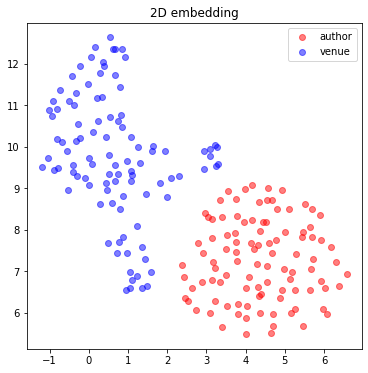

In [95]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6,6))
plt.scatter(z_auth_2d[:,0],z_auth_2d[:,1],color="red",alpha=0.5,label="author")
plt.scatter(z_venue_2d[:,0],z_venue_2d[:,1],color="blue",alpha=0.5,label="venue")
plt.legend()
plt.title("2D embedding")
plt.show()